#### Построение поля скоростей потенциала одиночной скважины
Потенциал скорости течения для одиночной скважины задан функцией $\phi_0(M,M_0)=f(x,y,x_0,y_0,\mu)$,где $M=(x,y),M_0=(x_0,y_0) $,$M_0$- координаты центра скважины, $\mu$-параметр проницаемости грунта
Построим поле скоростей для различных значений $\mu$ в заданной области D c M0 в центре D.

Замечание. Здесь и далее все величины безразмерные.

In [1]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np
import scipy.special as ss

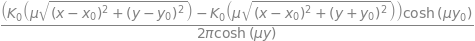

In [2]:
x,y,x0,y0,mu=sp.symbols("x y x0 y0 mu")
fi0=1/(2*sp.pi)*sp.cosh(mu*y0)/sp.cosh(mu*y)*(sp.besselk(0,mu*sp.sqrt((x-x0)**2+(y-y0)**2))-sp.besselk(0,mu*sp.sqrt((x-x0)**2+(y+y0)**2)))
sp.init_printing()
fi0

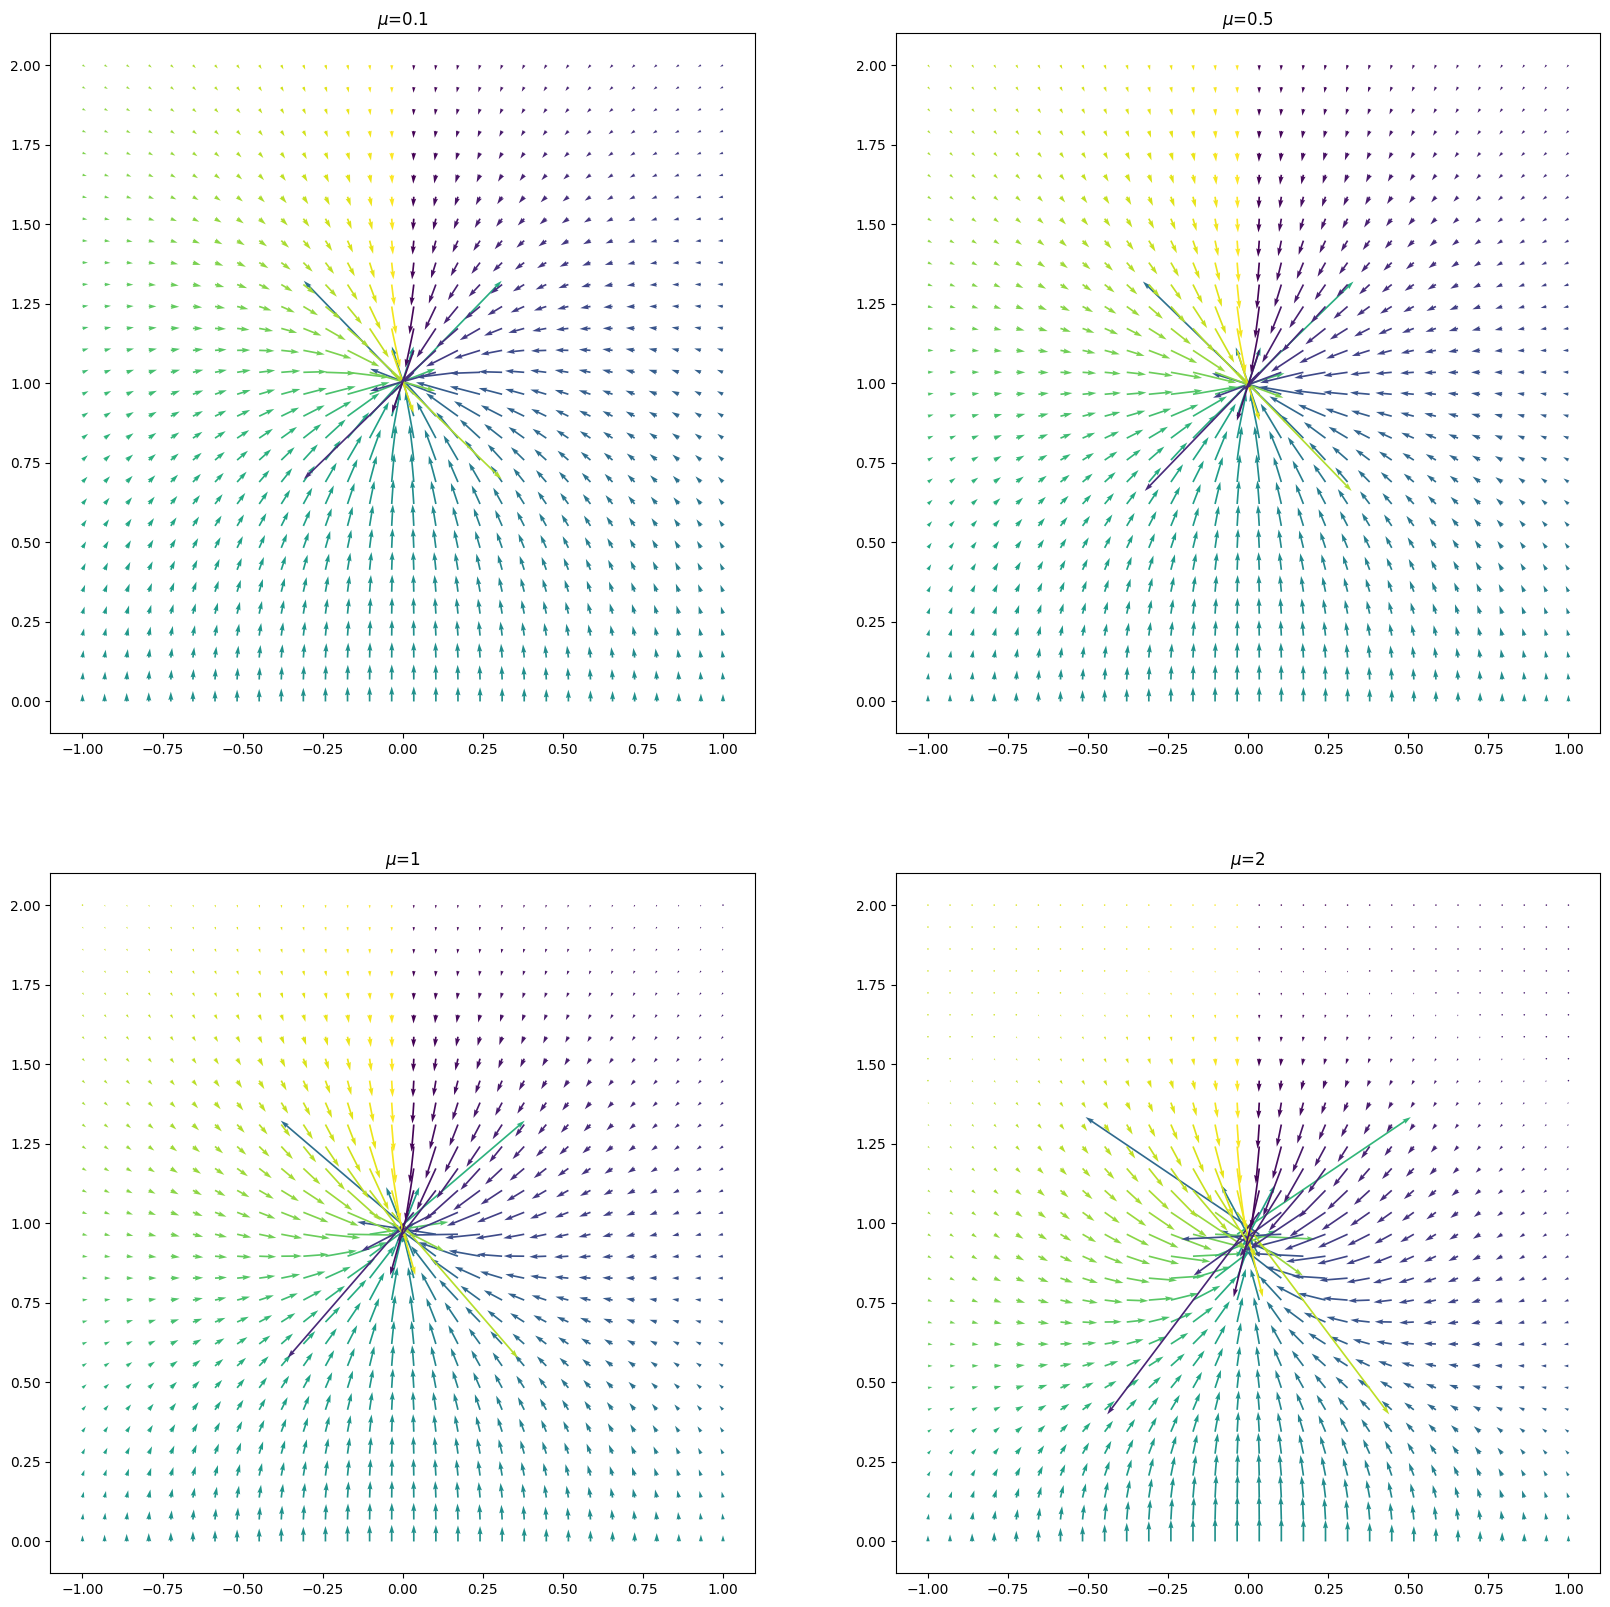

In [3]:
def calc_speed_field(M0,D,munum,fi0,n=30):
    """Считает поле скоростей при заданном потенциале fi0,
    при заданных численных значениях:
    M0-(x0,y0) - координаты центра скважины,
    D=(xbegin,xend,ybegin,yend) -область рассчета
    mu - список значений параметра проницаемости грунта
    n *n  - размер сетки
    Возвращает V={mu:[Vx,Vy]} - поля скоростей для каждого mu
    """
    #grid points
    xnum=np.linspace(D[0],D[1],n)
    ynum=np.linspace(D[2],D[3],n)
    grid=np.meshgrid(xnum,ynum)
    #derivatives
    dfi0_di=sp.diff(fi0,x),sp.diff(fi0,y)
    #Kn - modyfide bessel func 2kind
    mydic= {"besselk": ss.kn}
    V={m:[None,None] for m in munum}
    for m in munum:
        for i,der in enumerate(dfi0_di):
            dfdi=der.subs([(x0,M0[0]),(y0,M0[1]),(mu,m)])
            V[m][i]=sp.lambdify((x, y), dfdi, modules=('numpy',mydic)) (grid[0], grid[1])
    return V,grid

def show_speed_field_plots(V,grid,munum,path_to_save=None):
    ky=int(len(munum)**0.5)
    kx = len(munum)//ky if len(munum)%ky==0 else len(munum)//ky +1
    plt.rcParams["figure.figsize"] = (10*kx,10*ky)
    for i,m in enumerate(munum):
        C1=np.arctan2(V[m][0],V[m][1])
        plt.subplot(kx, ky, i+1,title='$\mu$={}'.format(m))
        plt.quiver(grid[0], grid[1], V[m][0], V[m][1],C1)
    if path_to_save is not None:
        plt.savefig(path_to_save+'mu{}.jpg'.format(m), dpi=200)
    plt.show()
    return

#D boundary points
D=[-1,1,0,2]
#point M0
M0=[(D[0]+D[1])/2,(D[2]+D[3])/2]
#mu values
munum=[0.1,0.5,1,2]
#number of segments
n=30
V,grid=calc_speed_field(M0,D,munum,fi0,n)
show_speed_field_plots(V,grid,munum)

Как видно из графиков, при увеличении mu, увеличиваются и скорости течения.

#### Исследование зависимости суммарного дебита системы скважин от параметров
Пусть есть система из k одинаковых скважин, расположенных на прямой,параллельной оси x,на одинаковом расстоянии dx друг от друга,симметрично относительно оси y
Потенциал скорости одиночной скважины задан функцией $\phi_0(M,M_0)=f(x,y,x_0,y_0,\mu)$.
Для различных значений параметра $\mu$ и расстояний dx при различном кол-ве скважин в системе $k=1..kmax$ вычислим дебиты скважин, суммарный дебит системы Qsum(k), вклад каждой новой k скважины $\eta = \frac{Qsum(k)}{Qsum(k-1)}-1$

Потенциал системы из k скважин:\
$\phi(M)=\sum^k_{i=1}q_i\phi_0(M,M_{0i}),где M_{0i}=(x_{0i},y_0)$ - координаты центров скважины, $q_i$ - дебиты скважин \
Чтобы найти дебиты скважин требуется удовлетворить потенциал граничными условия на контурах скважины:
$\phi(M)=С_i, M \in L_{Ci}$, где $C_i$ -давление на контурах скважины, $L_{Ci}$- контур скважины i\
Получится система уравнений\
$С_1=\phi(x01+Rc1,y0), ... ,C_k=\phi(x0k+Rck)$

In [4]:
import sympy as sp
import numpy as np
import scipy.special as ss
import pandas as pd

In [5]:
class Flow_rate_calculator:
    """Класс для расчета дебитов систем из 1..kmax скважин,расположенных на прямой
    для заданных параметров,также суммарного дебита систем, вклада каждой новой скажины в дебит системы"""
    def __init__(self,Mu,Dx,y0,Rc,C,kmax,fi0):
        """
        kmax-максимальное кол-во скважин в системе
        Mu - список параметров проницаемости грунта
        Dx - список расстояний между скважинами
        Rc - список радиуса контуров скважин 
        С- спискок давлений на контрурах скважины
        fi0 - функция потенциала одиночной скважины
        """
        self.__Dx=Dx.copy()
        self.__Mu=Mu.copy()
        self.__y0=y0
        self.__Rc=Rc.copy()
        self.__C=C.copy()
        self.__kmax=kmax
        self.__fi0=fi0
        self.__init_dicts()
    
    def __init_dicts(self): 
        self.__Q={}
        self.__QSum={}
        self.__Eta={}
        for mu in self.__Mu:
            self.__Q[mu]={}
            self.__QSum[mu]={}
            self.__Eta[mu]={}
            for dx in self.__Dx:
                self.__Q[mu][dx]=[[] for i in range(self.__kmax)]
                self.__QSum[mu][dx]=[None for k in range(kmax)]
                self.__Eta[mu][dx]=[None for k in range(kmax)]
    
    def __calc_Q(self):
        x,y=sp.symbols("x y")
        #символьные переменные
        Qs= [sp.Symbol("q" + str(i)) for i in range (kmax) ] #переменные дебита скважин q1...qk
        for mu in self.__Mu:
            for dx in self.__Dx:
                for k in range (1,self.__kmax+1):
                    #Задаем координаты k скважин для расстояния dx между скважинами - симметричные относительно точки (0,y00)
                    x0=[-dx*(k-1)/2+i*dx for i in range(0,k)] #численные значения x координат центра скважин
                    #потенциал
                    phi=0
                    for i in range(k):
                        phi+=Qs[i]*fi0(mu,x,y,x0[i],self.__y0)
                    #удовлетворяем потенциал граничным условиям на контурах скважин.
                    eq=[None for i in range(k)]
                    for i in range(k):
                        eq[i]=phi.subs([(x,x0[i]+self.__Rc[i])])-self.__C[i]
                        eq[i]=sp.lambdify(y,eq[i], modules=({"besselk": ss.kn})) (self.__y0)
                    #Решаем
                    Qk,=sp.solvers.linsolve(eq,Qs[:k])
                    #записываем все дебиты в словарь
                    self.__Q[mu][dx][k-1]=Qk
                                     
    def __calc_QSum_Eta(self):
        for mu in self.__Mu:
            for dx in self.__Dx:
                for k in range(kmax):
                    self.__QSum[mu][dx][k]=sum(self.__Q[mu][dx][k])
                    self.__Eta[mu][dx][k]=100 if k==0 else 100*(self.__QSum[mu][dx][k]/self.__QSum[mu][dx][k-1]-1)
                                     
    def calc_all(self):
        self.__calc_Q()
        self.__calc_QSum_Eta()
    
    def getQSum(self,mu,dx,k=None):
        if not (mu in self.__QSum):
            print("Значение mu="+str(mu)+" задано неверно")
            return 
        if not (dx in self.__QSum[mu]):
            print("Расстояние dx="+str(dx)+" задано неверно")
            return 
        if k is None:
            return self.__QSum[mu][dx].copy()
        if k<1 or k>self.kmax:
            print("Количество скважин k="+str(k)+" задано неверно")
            return 
        return self.__QSum[mu][dx][k-1]
    
    def getEta(self,mu,dx,k=None):
        if not (mu in self.__Eta):
            print("Значение mu="+str(mu)+" задано неверно")
            return 
        if not (dx in self.__Eta[mu]):
            print("Расстояние dx="+str(dx)+" задано неверно")
            return 
        if k is None:
            return self.__Eta[mu][dx].copy()
        if k<1 or k>self.__kmax:
            print("Количество скважин k= "+str(k)+" задано неверно")
            return 
        return self.__Eta[mu][dx][k-1]
                          
    def getQ(self,mu,dx,k,i=None):
        """Функция,возвращаящая дебиты q1 ... qk скважин для системы из ki скважин для параметров mu=mui, dx=dxi
        Если задан номер i конкретной скважины, то возвращается только ее дебит"""
        if not (mu in self.__Q):
            print("Значение mu="+str(mu)+" задано неверно")
            return 
        if not (dx in self.__Q[mu]):
            print("Расстояние dx="+str(dx)+" задано неверно")
            return
        if k<1 or k>self.__kmax:
            print("Количество скважин k="+str(k)+" задано неверно")
            return
        if i is None:
            return self.__Q[mu][dx][k-1].copy()
        if i<1 or i>k:
            print("Номер скважины i="+str(i)+" задан неверно")
            return
        return self.__Q[mu][dx][k-1][i-1]
    
    def printQ(self,mu,dx,k,i=None):
        Q=self.getQ(mu,dx,k,i)
        if Q is None:
            return
        if i is None:
            print("Дебиты k="+str(k)+" скважин для mu="+str(mu)+", dx="+str(dx))
        else:
            print("Дебит i="+str(i)+"й скважины в системе из k="+str(k)+" скважин для mu="+str(mu)+", dx="+str(dx))
        print(Q)

                          
    def show_table(self,mu,dx,table_number=None):
        if self.getQSum(mu,dx) is None or self.getEta(mu,dx) is None:
            return
        k=[str(i) for i in range(1,kmax+1)]# количество скважин
        data=np.array([self.__QSum[mu][dx],self.__Eta[mu][dx]],dtype=float)
        table=pd.DataFrame(data,
                           index=["Суммарный дебит", "Вклад kй скважины (%)"],
                           columns=pd.Index(k,name="Кол-во скважин "))
        table_name="Сравнение суммарных дебитов от 1 до {} скважин для расстояния между ними dx={} и mu={}".format(self.__kmax,dx,mu)
        tn="" if table_number is None else "Таблица {}. ".format(table_number)
        s=table.style.set_caption(tn+table_name).set_table_styles([{'selector': 'caption',
                                                                 'props': [('color', 'black'),
                                                                           ('font-size', '15px'),
                                                                          ("text-align", "center")]}])
        s.format(precision=2)
        display(s)
    
    def show_all_tables(self):
        i=1
        for mu in self.__Mu:
            for dx in self.__Dx:
                self.show_table(mu,dx,i)
                i+=1

def fi0(mu,x,y,x0,y0):
    """Потенциал одиночной скважины"""
    return 1/(2*sp.pi)*sp.cosh(mu*y0)/sp.cosh(mu*y)*(sp.besselk(0,mu*sp.sqrt((x-x0)**2+(y-y0)**2))-sp.besselk(0,mu*sp.sqrt((x-x0)**2+(y+y0)**2)))

y0=1 # значение y координаты центра скважин - одинаковая у всех.
Dx=[0.05*y0,0.2*y0] #  расстояние между скважинами
Mu=[0.1,1.] #значение коэффициента проницаемости
kmax=10 #- максимальное количество скважин в задаче
Rc=[0.001*y0 for i in range(kmax)]
C=[1 for i in range(kmax)]
Qcalc=Flow_rate_calculator(Mu,Dx,y0,Rc,C,kmax,fi0)
Qcalc.calc_all()

In [6]:
Qcalc.show_all_tables()

Кол-во скважин,1,2,3,4,5,6,7,8,9,10
Суммарный дебит,0.83,1.12,1.31,1.46,1.58,1.70,1.80,1.90,1.99,2.07
Вклад kй скважины (%),100.00,34.81,16.98,11.39,8.70,7.12,6.08,5.34,4.79,4.36


Кол-во скважин,1,2,3,4,5,6,7,8,9,10
Суммарный дебит,0.83,1.28,1.62,1.91,2.18,2.43,2.67,2.91,3.14,3.36
Вклад kй скважины (%),100.00,53.71,26.74,18.20,14.05,11.59,9.95,8.77,7.88,7.17


Кол-во скважин,1,2,3,4,5,6,7,8,9,10
Суммарный дебит,0.91,1.27,1.52,1.72,1.90,2.06,2.21,2.36,2.49,2.63
Вклад kй скважины (%),100.00,39.44,19.65,13.39,10.34,8.55,7.35,6.50,5.86,5.36


Кол-во скважин,1,2,3,4,5,6,7,8,9,10
Суммарный дебит,0.91,1.47,1.93,2.36,2.76,3.14,3.53,3.90,4.28,4.65
Вклад kй скважины (%),100.00,61.63,31.54,21.82,17.01,14.11,12.14,10.70,9.60,8.71


In [7]:
# Примеры дебитов скважин
Qcalc.printQ(1.0,0.2,10)
Qcalc.printQ(1.0,0.2,10,1)

Дебиты k=10 скважин для mu=1.0, dx=0.2
(0.602333469516816, 0.478574673460802, 0.431524393839546, 0.410419821901434, 0.401945226018252, 0.401938936705892, 0.410405580382908, 0.431528681367975, 0.478732526621728, 0.603691111286063)
Дебит i=1й скважины в системе из k=10 скважин для mu=1.0, dx=0.2
0.602333469516816


Вывод


Посмотрим на таблицу 1

Расстояние между скважинами dx=0.05
С увеличением количества скважин в системе суммарный дебит системы возрастает,
однако вклад каждой новой скважины в суммарный дебит системы($\eta$) уменьшается из-за интерференции скважин-
они ослабляют друг друга. 
Для 10й скважины он будет порядка 4,4% что можно уже считать довольно малым значением,
следовательно добавлять 10ю скважину в систему не обязательно.

Посмотрим на таблицу 2

Для расстояния между скважинами dx=0.2
По сравнению со значениями из таблицы 1 больше и суммарный дебит системы и ета,
тк скважины дальше друг от друга они меньше интерферируют.
Для 10й скважины вклад около 7.2%, будем считать что этого достаточно,чтобы ее добавить.

Посмотрим на таблицы 2 и 4

для mu1=0.1 суммарный дебит систем и этта меньше, чем для  mu2=1. 
Например вклад 10й скважины 7.2% mu1 по сравнению с 8.7% для mu2.
Те для более проницаемого грунта с mu2 интерференция скважин меньше,а суммарный дебит системы больше,чем для mu1 при одинаковом расстоянии.

Итого \
Для выбора оптимального количества скважин в системе необходимо учитывать такие параметры,
как расстояние между скважинами и проницаемость грунта.
С увеличением расстояния и проницаемости уменьшается взаимное влияние скважин друг на друга
и возрастает суммарный дебит системы.